# Bedrock Claude 및 LangGraph 를 이용한 Prompt Flow - [Basic]

In [1]:
!python -V

Python 3.10.14


# 0. 환경 설정

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../.."
add_python_path(module_path)

python path: /home/sagemaker-user is added
sys.path:  ['/home/sagemaker-user/miridih-test/langgraph', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user']


In [3]:
!pip show pydantic

Name: pydantic
Version: 2.7.0
Summary: Data validation using Python type hints
Home-page: https://github.com/pydantic/pydantic
Author: 
Author-email: Samuel Colvin <s@muelcolvin.com>, Eric Jolibois <em.jolibois@gmail.com>, Hasan Ramezani <hasan.r67@gmail.com>, Adrian Garcia Badaracco <1755071+adriangb@users.noreply.github.com>, Terrence Dorsey <terry@pydantic.dev>, David Montague <david@pydantic.dev>, Serge Matveenko <lig@countzero.co>, Marcelo Trylesinski <marcelotryle@gmail.com>, Sydney Runkle <sydneymarierunkle@gmail.com>, David Hewitt <mail@davidhewitt.io>, Alex Hall <alex.mojaki@gmail.com>
License: 
Location: /opt/conda/lib/python3.10/site-packages
Requires: annotated-types, pydantic-core, typing-extensions
Required-by: amazon_sagemaker_jupyter_scheduler, anthropic, confection, fastapi, gluonts, jupyter_scheduler, langchain, langchain-core, langsmith, sagemaker-core, sagemaker-jupyterlab-extension-common, spacy, thinc, weasel


## Bedrock Client 생성

In [4]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

### 모델 ID 및 Bedrock converse API 정의

In [5]:
from utils.bedrock import *

model_id = "anthropic.claude-3-haiku-20240307-v1:0"
# model_id = "anthropic.claude-3-5-sonnet-20240620-v1:0"


### 프롬프트의 베이스가 되는 프롬프트 템플릿 파일 기술

In [6]:
from utils.cross_region_inference_prompt_util import *

# 프롬프트 템플릿 파일의 경로를 지정
prompt_folder = "prompt_template"
outline_prompt_file_name = "outline_prompt_template.txt"
slide_prompt_file_name = "slide_prompt_template.txt"

In [7]:
# # 프레젠테이션의 개요 생성 prompt template 로딩 및 토픽 추가

from jinja2 import Template

prompt_file_path = os.path.join(prompt_folder, outline_prompt_file_name)

template_content = load_template_from_file(prompt_file_path)
PROMPT_TEMPLATE = Template(template_content)

TOPIC = "2024년의 한국 부동산 시장 현황"
outline_prompt = PROMPT_TEMPLATE.render(topic=TOPIC)

print(outline_prompt)

You are an expert in creating impactful and professional PowerPoint presentations. 
Create a detailed outline for a 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Analyze the given topic thoroughly to write in the provided <output_format> JSON format.
Return only the JSON object without additional tags or explanations.

<context>
2024년의 한국 부동산 시장 현황
</context>

<instruction>
1. Title:
   - Create a compelling and concise main title that captures the essence of the presentation.

2. Slides:
   - Generate 10 slides, including an opening and a closing slide.
   - For each slide:
     - Assign a slide_number (01 to 10).
     - Create a clear and informative slide_title.
     
3. Content Guidelines:
   - Ensure a logical flow and structure throughout the presentation.
   - Include an introduction slide (slide 02) and a conclusion slide (slide 09).   

4. Common Points:
   - Include the most important keywords related to the topic.
   - Ens

In [8]:
# # 슬라이드 내용 생성 prompt template 로딩

prompt_file_name = "slide_prompt_template.txt"

slide_prompt_file_path = os.path.join(prompt_folder, prompt_file_name)

template_content = load_template_from_file(slide_prompt_file_path)
slide_prompt_template = Template(template_content)
slide_prompt = slide_prompt_template.render()

print("\n## Slide prompt template...")
print(slide_prompt)


## Slide prompt template...
You are an expert in creating impactful and professional PowerPoint presentations.
Your task is to create detailed content for a specific slide in 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Based on this  of the , Generate detailed content for slides  to .
For each slide, include:
1. Slide title
2. Main content points (3-5 bullet points)
3. Relevant data or examples
4. Suggesion for visuals (e.g., image, chart, graph)
5. A brief speaker note (1-2 sentences)


# 1. Graph 정의

#### 그래프 정의
- State 정의
- 그래프 빌더 정의
- 노드, 에지 정의
- 그래프 컴파일

## 버전1: Aggregated graph - 프레젠테이션 1-5장, 6-10장 생성하는 노드 동시에 돌리기

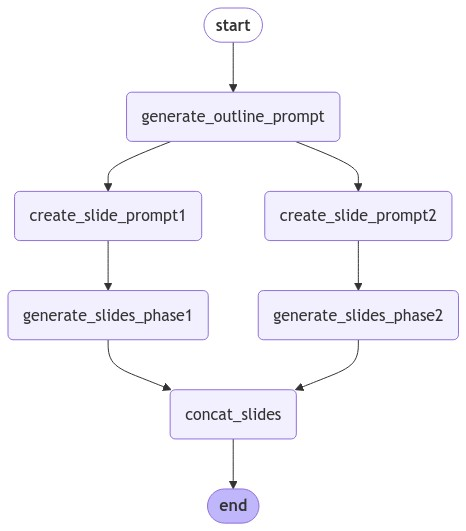

In [2]:
from typing import TypedDict, Annotated, Any
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage



# State 정의
class State(TypedDict):
    topic: Annotated[str, "프레젠테이션 주제"]
    outline_prompt: Annotated[str, "프레젠테이션 개요 생성을 위해 실행할 프롬프트"]
    outline: Annotated[str, "프레젠테이션 개요"]
    # slide_titles: Annotated[list, "슬라이드 타이틀 모음"]
    slide_prompt1: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    slide_prompt2: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    response_phase1: Annotated[str, "슬라이드 1-5장 내용"]
    response_phase2: Annotated[str, "슬라이드 6-10장 내용"]
    completed_content: Annotated[str, "최종 생성된 프레젠테이션 내용"]

# 프레젠테이션 개요 생성 노드 정의
def generate_outline_prompt(state: State) -> State:
    # llm = get_llm_model(model_id="claude-3-haiku-20240307):
    prompt = state["outline_prompt"]
    
    response = converse_invoke(boto3_bedrock, model_id, prompt)  
    # response = converse_invoke_with_backoff(boto3_bedrock, model_id, prompt)
    
    # print("response: \n", response)
    output_message = response['output']['message']['content'][0]['text']    
    # response = llm_sonnet.invoke([HumanMessage(content=prompt)])
    return State(outline=output_message)


# # 생성한 프레젠테이션의 타이틀만 뽑아내는 노드 정의
# def extract_slide_titles(state: State) -> State:
#     # JSON 문자열을 Python 딕셔너리로 파싱
#     outline = state["outline"]
#     slide_titles = []
#     data = json.loads(outline) if isinstance(outline, str) else outline
#     # 메인 타이틀 출력
#     # title = data['title']
#     # 슬라이드 리스트를 순회하며 각 슬라이드의 제목 출력
#     print("\n## Extract each slide titles in outline...")
#     for slide in data['slides']:
#         print(slide)
#         slide_titles.append(slide['slide_title'])
#     return State(slide_titles=slide_titles)


def create_slide_prompt1(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 1-5...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt1 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 1,
        end_slide = 5
    )
    print("\n### Generated Prompt for slides 1-5...")
    print(slide_prompt1)
    return State(slide_prompt1=slide_prompt1)


def create_slide_prompt2(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 6-10...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt2 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 6,
        end_slide = 10
    )
    print("\n### Generated Prompt for slides 6-10...")
    print(slide_prompt2)
    return State(slide_prompt2=slide_prompt2)


def generate_slides_phase1(state:State) -> State:
    slide_prompt1 = state["slide_prompt1"]
    print("\n## Generating content for slides 1-5...")
    
    response1 = converse_invoke(boto3_bedrock, model_id, slide_prompt1)
    # response1 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt1)
    
    output_message1 = response1['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 1-5...") 
    print(output_message1)
    return State(response_phase1=output_message1)


def generate_slides_phase2(state:State) -> State:
    slide_prompt2 = state["slide_prompt2"]
    print("\n## Generating content for slides 6-10...")
 
    response2 = converse_invoke(boto3_bedrock, model_id, slide_prompt2)
    # response2 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt2)

    output_message2 = response2['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 6-10...") 
    print(output_message2)
    return State(response_phase2=output_message2)


def concat_slides(state:State) -> State:
    response_phase1=state["response_phase1"]
    response_phase2=state["response_phase2"]
    merged_response = response_phase1 + response_phase2
    print("\n## Merged contents...")
    print(merged_response)
    return State(completed_content=merged_response)


# 그래프 정의
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("generate_outline_prompt", generate_outline_prompt)
graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
graph_builder.add_node("create_slide_prompt1", create_slide_prompt1)
graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
graph_builder.add_node("create_slide_prompt2", create_slide_prompt2)
graph_builder.add_node("concat_slides", concat_slides)

# Define the flow of execution
graph_builder.add_edge(START, "generate_outline_prompt")
graph_builder.add_edge("generate_outline_prompt", "create_slide_prompt1")
graph_builder.add_edge("generate_outline_prompt", "create_slide_prompt2")
graph_builder.add_edge("create_slide_prompt1", "generate_slides_phase1")
graph_builder.add_edge("create_slide_prompt2", "generate_slides_phase2")

# Ensure concat_slides runs only after both generate_slides_phase1 and generate_slides_phase2
graph_builder.add_edge("generate_slides_phase1", "concat_slides")
graph_builder.add_edge("generate_slides_phase2", "concat_slides")

# End the graph
graph_builder.add_edge("concat_slides", END)


# 그래프 컴파일
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 그래프를 실행할 함수 정의

In [10]:
def run_prompt(outline_prompt: str, topic: str, response_phase1: list, response_phase2: list, completed_content: list ):
    # inputs = {"prompt": prompt,"topic": topic}
    result = graph.invoke(State(outline_prompt=outline_prompt, topic=topic, response_phase1=response_phase1, response_phase2=response_phase1, completed_content=completed_content))
    # result = graph.invoke(input)
    return result["completed_content"]

### 그래프 실행

In [11]:
run_prompt(outline_prompt,TOPIC,[],[],[])


## Generating prompt for creating the content of slides 1-5...


### Generated Prompt for slides 1-5...
You are an expert in creating impactful and professional PowerPoint presentations.
Your task is to create detailed content for a specific slide in 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Based on this {
    "title": "2024년 한국 부동산 시장 동향",
    "slides": [
        {
            "slide_number": "01",
            "slide_title": "표지"
        },
        {
            "slide_number": "02", 
            "slide_title": "소개"
        },
        {
            "slide_number": "03",
            "slide_title": "부동산 시장 개관"
        },
        {
            "slide_number": "04",
            "slide_title": "주요 도시 부동산 가격 동향"
        },
        {
            "slide_number": "05",
            "slide_title": "신규 주거 개발 프로젝트"
        },
        {
            "slide_number": "06",
            "slide_title": "정부 정책 및 규제"
        },
        {
          

'1. 표지 슬라이드\n\n슬라이드 제목: 2024년 한국 부동산 시장 동향\n\n주요 내용:\n- 프레젠테이션의 주제와 목적 소개\n- 주요 섹션 미리보기\n\n관련 데이터/예시: 없음\n\n제안 시각자료: 프레젠테이션 표지 디자인 및 로고\n\n연사 노트: 청중에게 환영 인사와 간단한 자기소개를 하고 프레젠테이션의 개요를 설명합니다.\n\n2. 소개 슬라이드 \n\n슬라이드 제목: 부동산 시장의 중요성\n\n주요 내용:\n- 부동산 시장이 경제에 미치는 영향력\n- 주거, 상업 및 투자 측면의 중요성\n- 한국 부동산 시장의 특징과 동향 파악의 필요성\n\n관련 데이터/예시: 부동산 GDP 기여도, 가계 자산 중 부동산 비중 등\n\n제안 시각자료: 부동산 시장 규모 또는 기여도를 보여주는 차트\n\n연사 노트: 부동산 시장의 중요성을 강조하고 한국 시장 동향 분석의 목적을 설명합니다.\n\n3. 부동산 시장 개관 슬라이드\n\n슬라이드 제목: 2024년 한국 부동산 시장 개관\n\n주요 내용: \n- 전국 주택 가격 동향 (상승/하락률)\n- 주요 도시별 가격 변동 추이\n- 주택 유형별 (아파트, 단독주택 등) 가격 변화\n- 공급 및 거래량 현황\n\n관련 데이터/예시: 주택가격지수, 주택거래량 통계 등\n\n제안 시각자료: 주택가격 변동 추이 그래프, 지역별 가격 분포 지도\n\n연사 노트: 전반적인 시장 동향을 개괄적으로 설명하고 주요 지표를 강조합니다.\n\n4. 주요 도시 부동산 가격 동향 슬라이드  \n\n슬라이드 제목: 수도권 및 주요 광역시 부동산 가격 동향\n\n주요 내용:\n- 서울, 인천, 경기 등 수도권 지역 가격 변동\n- 부산, 대구, 광주 등 광역시 가격 추이\n- 주요 요인 (규제, 수요, 공급 등) 분석\n- 지역별 가격 격차 현황\n\n관련 데이터/예시: 주요 도시 주택가격지수, 가격 대비 소득 배율 등\n\n제안 시각자료: 도시별 가격 변동 그래프, 히트맵 등\n\n연사 노트: 주요 대도시 지역의 가격 동향을 중점적으로

## 버전2: Simple graph - 순차적으로 1-5번 슬라이드가 만들어진 후에 6-10번 슬라이드를 만들어보기

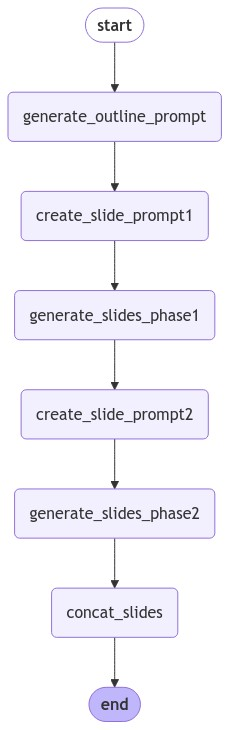

In [12]:
from typing import TypedDict, Annotated, Any
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage
import operator


# Stage 정의
class State(TypedDict):
    topic: Annotated[str, "프레젠테이션 주제"]
    outline_prompt: Annotated[str, "프레젠테이션 개요 생성을 위해 실행할 프롬프트"]
    outline: Annotated[str, "프레젠테이션 개요"]
    slide_titles: Annotated[list, "슬라이드 타이틀 모음"]
    slide_prompt1: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    slide_prompt2: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    response_phase1: Annotated[list, "슬라이드 1-5장 내용"]
    response_phase2: Annotated[list, "슬라이드 6-10장 내용"]
    completed_content: Annotated[list, "최종 생성된 프레젠테이션 내용"]

    

# 프레젠테이션 개요 생성 노드 정의
def generate_outline_prompt(state: State) -> State:
    # llm = get_llm_model(model_id="claude-3-haiku-20240307):
    prompt = state["outline_prompt"]
    response = converse_invoke(boto3_bedrock, model_id, prompt)    
    # print("response: \n", response)
    output_message = response['output']['message']['content'][0]['text']    
    # response = llm_sonnet.invoke([HumanMessage(content=prompt)])
    return State(outline=output_message)


# 생성한 프레젠테이션의 타이틀만 뽑아내는 노드 정의
def extract_slide_titles(state: State) -> State:
    # JSON 문자열을 Python 딕셔너리로 파싱
    outline = state["outline"]
    slide_titles = []
    data = json.loads(outline) if isinstance(outline, str) else outline
    # 메인 타이틀 출력
    # title = data['title']
    # 슬라이드 리스트를 순회하며 각 슬라이드의 제목 출력
    print("\n## Extract each slide titles in outline...")
    for slide in data['slides']:
        print(slide)
        slide_titles.append(slide['slide_title'])
    return State(slide_titles=slide_titles)


def create_slide_prompt1(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 1-5...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt1 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 1,
        end_slide = 5
    )

    # print(slide_prompt1)
    return State(slide_prompt1=slide_prompt1)

def create_slide_prompt2(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 6-10...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt2 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 6,
        end_slide = 10
    )

    # print(slide_prompt2)
    return State(slide_prompt2=slide_prompt2)

def generate_slides_phase1(state:State) -> State:
    slide_prompt1 = state["slide_prompt1"]
    print("\n## Generating content for slides 1-5...")
    print("\n## Prompt for slides 1-5...")
    print(slide_prompt1)
    
    response1 = converse_invoke(boto3_bedrock, model_id, slide_prompt1)

    output_message1 = response1['output']['message']['content'][0]['text']
    print("\n## Generated content for slides 1-5...") 
    print(output_message1)
    return State(response_phase1=output_message1)


def generate_slides_phase2(state:State) -> State:
    slide_prompt2 = state["slide_prompt2"]
    print("\n## Generating content for slides 6-10...")
    print("\n## Prompt for slides 6-10...")
    print(slide_prompt2)
    
    response2 = converse_invoke(boto3_bedrock, model_id, slide_prompt2)

    output_message2 = response2['output']['message']['content'][0]['text']
    print("\n## Generated content for slides 6-10...") 
    print(output_message2)
    return State(response_phase2=output_message2)

def concat_slides(state:State) -> State:
    response_phase1=state["response_phase1"]
    response_phase2=state["response_phase2"]
    merged_response = response_phase1 + response_phase2
    print("\n## Merged contents...")
    print(merged_response)
    return State(completed_content=merged_response)


# 그래프 정의
graph_builder = StateGraph(State)


# 노드, 엣지 추가 
graph_builder.add_node("generate_outline_prompt", generate_outline_prompt)
graph_builder.add_edge(START, "generate_outline_prompt")

graph_builder.add_node("create_slide_prompt1", create_slide_prompt1)
graph_builder.add_node("create_slide_prompt2", create_slide_prompt2)
graph_builder.add_edge("generate_outline_prompt", "create_slide_prompt1")

graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
graph_builder.add_edge("create_slide_prompt1", "generate_slides_phase1")
graph_builder.add_edge("generate_slides_phase1", "create_slide_prompt2")
graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
graph_builder.add_edge("create_slide_prompt2","generate_slides_phase2")

graph_builder.add_node("concat_slides", concat_slides)
graph_builder.add_edge("generate_slides_phase2", "concat_slides")
graph_builder.add_edge("concat_slides",END)


# 그래프 컴파일
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 그래프를 실행할 함수 정의

In [13]:
def run_prompt(outline_prompt: str, topic: str, response_phase1: list, response_phase2: list, completed_content: list ):
    # inputs = {"prompt": prompt,"topic": topic}
    result = graph.invoke(State(outline_prompt=outline_prompt, topic=topic, response_phase1=response_phase1, response_phase2=response_phase1, completed_content=completed_content))
    # result = graph.invoke(input)
    return result["completed_content"]

### 그래프 실행

In [14]:
run_prompt(outline_prompt,TOPIC,[],[],[])


## Generating prompt for creating the content of slides 1-5...


## Generating content for slides 1-5...

## Prompt for slides 1-5...
You are an expert in creating impactful and professional PowerPoint presentations.
Your task is to create detailed content for a specific slide in 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Based on this {
    "title": "2024 한국 부동산 시장 현황과 전망",
    "slides": [
        {
            "slide_number": "01",
            "slide_title": "표지 및 소개"
        },
        {
            "slide_number": "02",
            "slide_title": "2024년 부동산 시장 개요"
        },
        {
            "slide_number": "03",
            "slide_title": "주거용 부동산 동향"
        },
        {
            "slide_number": "04",
            "slide_title": "상업용 부동산 동향"
        },
        {
            "slide_number": "05",
            "slide_title": "투자 기회와 위험 요인"
        },
        {
            "slide_number": "06",
            "slide_title":

'1. Slide 1: 표지 및 소개\n\n- 프레젠테이션 제목: "2024 한국 부동산 시장 현황과 전망"\n- 주요 내용:\n  - 한국 부동산 시장의 최근 동향과 2024년 전망 소개\n  - 주거용, 상업용 부동산 시장 동향 및 투자 기회 탐색\n  - 정부 정책, 기술 혁신, 지속가능성 트렌드 등 영향 요인 분석\n- 예상 시청자: 투자자, 개발업체, 정책 입안자 등\n- 제안 시각 자료: 한국 지도 또는 랜드마크 건물 이미지\n- 발표자 노트: 개요 및 주요 주제 소개, 청중의 관심 환기\n\n2. Slide 2: 2024년 부동산 시장 개요\n\n- 부동산 시장 전반에 대한 거시적 전망 제시\n- 주요 내용:\n  - 경제 성장률, 금리, 인구 통계 등 주요 지표 전망\n  - 2024년 부동산 시장 규모 및 성장률 예측\n  - 지역별, 유형별 수요 및 공급 동향 분석\n- 관련 데이터: 부동산 가격 지수, 거래량 통계, GDP 성장률 등\n- 제안 시각 자료: 부동산 시장 규모 및 성장률 차트\n- 발표자 노트: 전반적인 시장 상황을 간략히 설명하고 이후 세부 내용으로 연결\n\n3. Slide 3: 주거용 부동산 동향\n\n- 주택, 아파트, 빌라 등 주거용 부동산 시장 동향 분석\n- 주요 내용:\n  - 주요 도시별 주택 가격 및 거래량 동향\n  - 신규 주택 공급 현황 및 계획\n  - 1인 가구, 청년층, 노령층 등 수요 계층별 니즈 분석\n- 관련 데이터: 주택 가격 및 거래량 통계, 신규 주택 공급 계획 등\n- 제안 시각 자료: 도시별 주택 가격 지수 그래프 또는 지도\n- 발표자 노트: 주거용 부동산 시장의 주요 동향과 수요 계층별 특성 설명\n\n4. Slide 4: 상업용 부동산 동향\n\n- 오피스, 리테일, 호텔, 물류 등 상업용 부동산 시장 동향 분석\n- 주요 내용:\n  - 주요 도시별 오피스, 상가 공실률 및 임대료 동향\n  - 신규 상업 시설 개발 계획 및 투자 기회\n  - 전자상거래, 원격근무 등 트렌드가